Revised Exact Experiment where we use strict orders over fragments with Borda scores in order to more closely mimic the NSF setting.


In [1]:
### Standard Magic and startup initializers.

import math
import csv
import numpy as np
import random
import itertools
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

_DEBUG = False

from peerselect import impartial
from peerselect import profile_generator

%matplotlib inline
matplotlib.style.use('bmh')

font = {'size'   : 14}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3)

#random.seed(15)

class Impartial:
    VANILLA = "Vanilla"
    EXACT = "ExactDollarPartition"
    PARTITION = "Partition"
    DPR = "DollarPartitionRaffle"
    CREDIABLE = "CredibleSubset"
    RAFFLE = "DollarRaffle"
    ALL = (VANILLA, EXACT, PARTITION, RAFFLE, CREDIABLE, DPR)

s = 1
test_n = [100]
test_k = [20, 25]
test_m = [10, 20]
test_l = [3, 5]
test_p = [0.1]

# Map for all Results.
results = {}
for n,k,m,l,p in itertools.product(test_n, test_k, test_m, test_l, test_p):
    agents = np.arange(0, n)
    # Containers for Results
    count_results = {x:[0]*k for x in Impartial.ALL}

    for c_sample in range(s):
        # Generate a profile and clustering
        profile = profile_generator.generate_mallows_mixture_profile(agents, agents, [1.0], [agents], [p])
        clustering = impartial.even_partition_order(sorted(agents, key=lambda j: random.random()), l)
        
        # Generate an m-regular assignment with borda scores.
        m_assignment = profile_generator.generate_approx_m_regular_assignment(agents, m, clustering, randomize=True)
        score_matrix = profile_generator.strict_m_score_matrix(profile, m_assignment, np.arange(m, 0, -1))
        #Compute Target Set.
        target_set = impartial.vanilla(score_matrix, k)
        
        # Capture the winning sets
        ws = {}
        # Let everyone else have the same size set so they are all compareable.
        ws[Impartial.VANILLA] = [i for i,j in impartial.vanilla(score_matrix, k)]
        
        # Let CRED, PART, and RAFFLE have bigger sets...
        ws[Impartial.EXACT] = impartial.exact_dollar_partition_explicit(score_matrix, k, clustering, normalize=True)
        ws[Impartial.PARTITION] = impartial.partition_explicit(score_matrix, k, clustering, normalize=False)
        
        ws[Impartial.CREDIABLE] = impartial.credible_subset(score_matrix, k, m, normalize=False)
        ws[Impartial.DPR] = impartial.dollar_raffle_explicit(score_matrix, k, clustering, normalize=True)
        #Call Raffle and have everyone in a cluster by themselves = Dollar.
        ws[Impartial.RAFFLE] = impartial.dollar_raffle(score_matrix, k, n, randomize=True, normalize=True)
        
        target_order = sorted(target_set, key=lambda x:x[1], reverse=True)
        for i, tup in enumerate(target_order):
            for x in Impartial.ALL:
                if tup[0] in ws[x]: count_results[x][i] += 1
    t = (n, k, m, l, p, s)
    results[t] = count_results
    print("Finished: " + ",".join([str(x) for x in [n, k, m, l, p]]))
print("Done")

Finished: 100,20,10,3,0.1
Finished: 100,20,10,5,0.1
Finished: 100,20,20,3,0.1
Finished: 100,20,20,5,0.1
Finished: 100,25,10,3,0.1
Finished: 100,25,10,5,0.1
Finished: 100,25,20,3,0.1
Finished: 100,25,20,5,0.1
Done


dict_keys([(50, 20, 20, 5, 0.1, 10), (50, 20, 10, 5, 0.1, 10), (50, 20, 20, 3, 0.1, 10), (50, 25, 10, 3, 0.1, 10), (50, 20, 10, 3, 0.1, 10), (50, 25, 20, 5, 0.1, 10), (50, 25, 10, 5, 0.1, 10), (50, 25, 20, 3, 0.1, 10)])


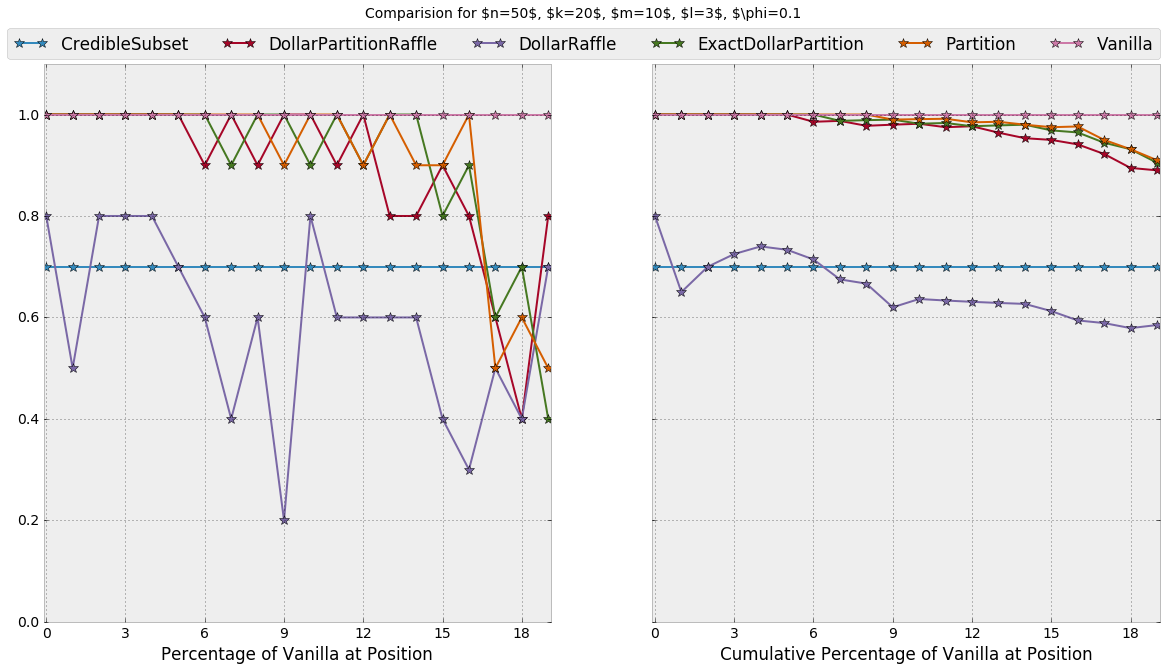

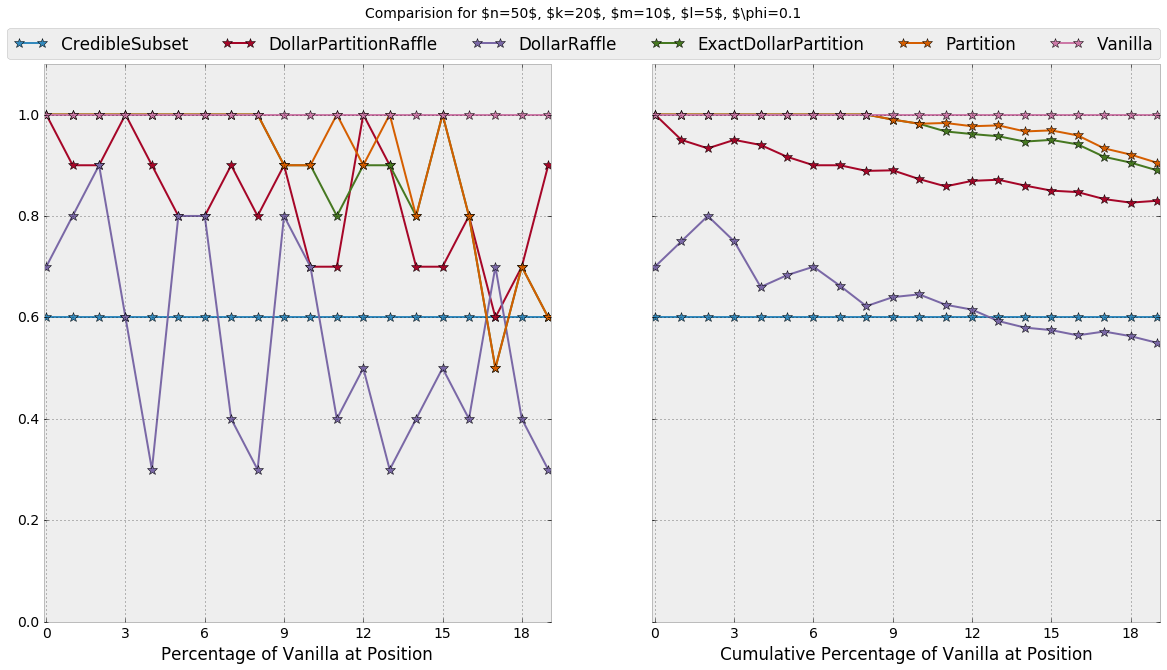

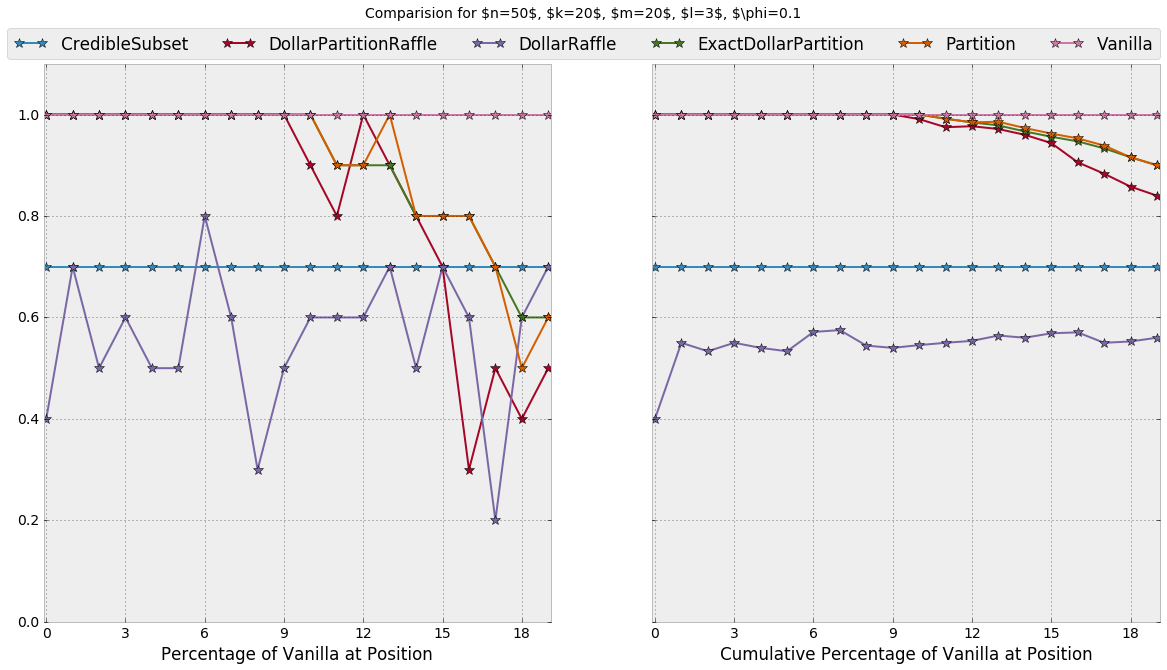

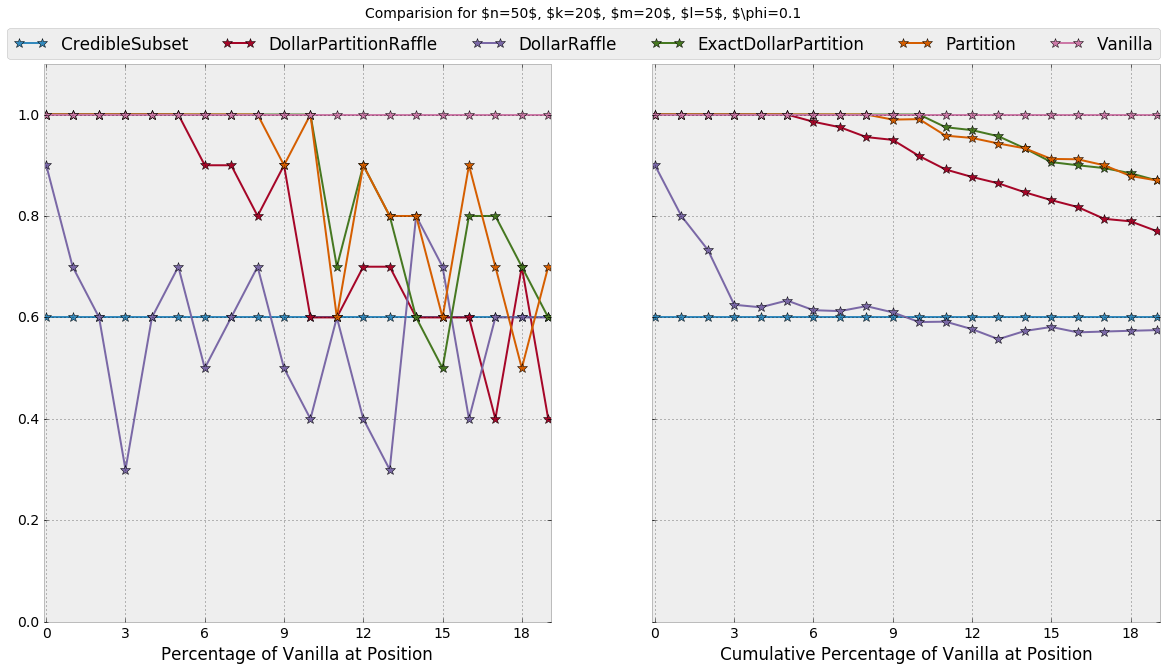

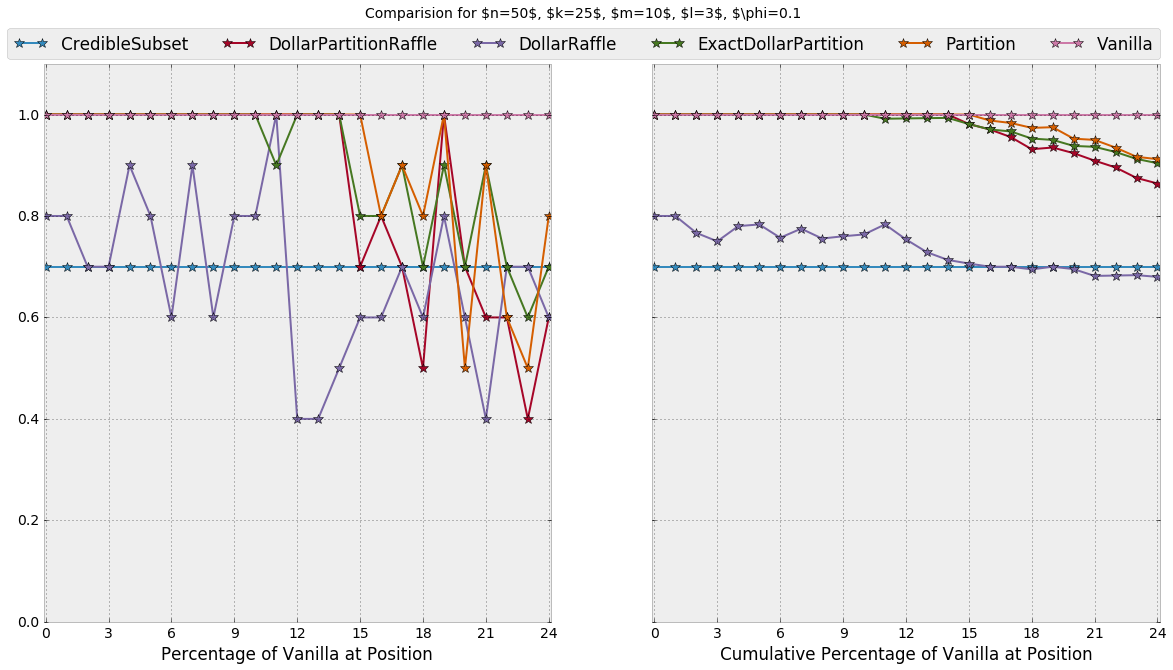

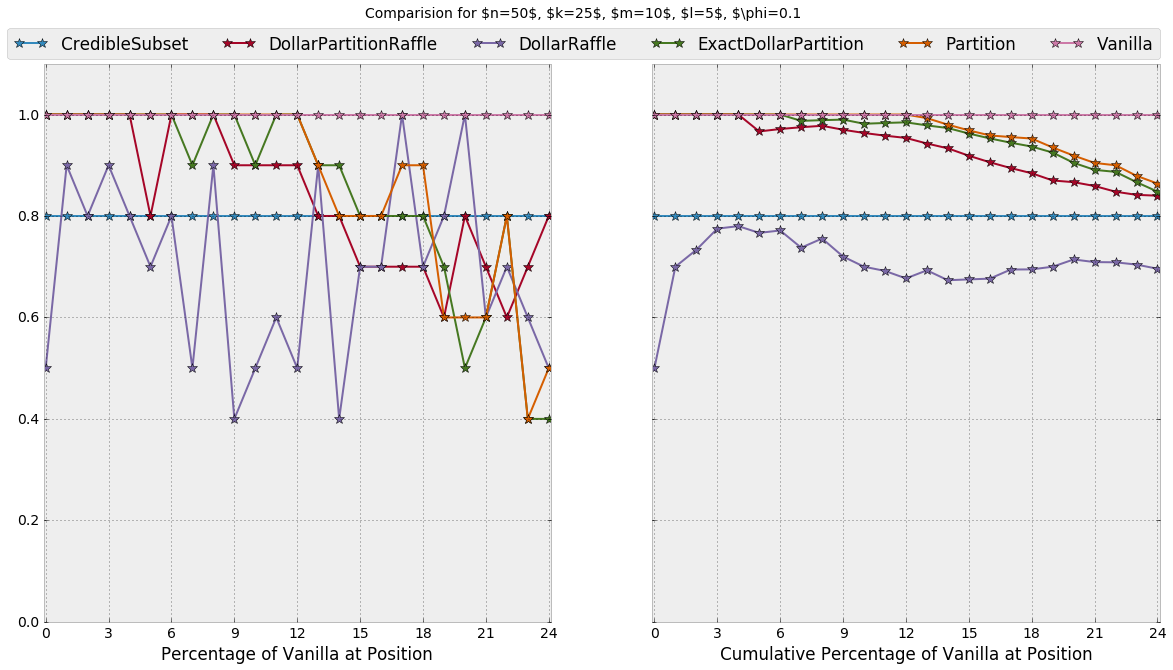

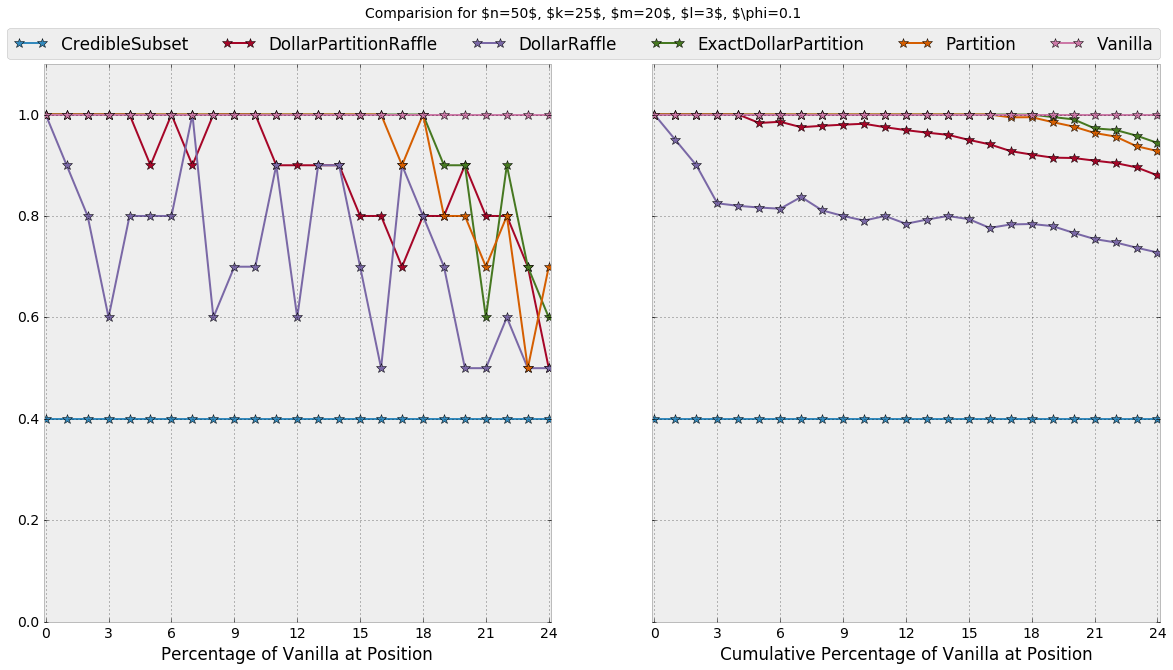

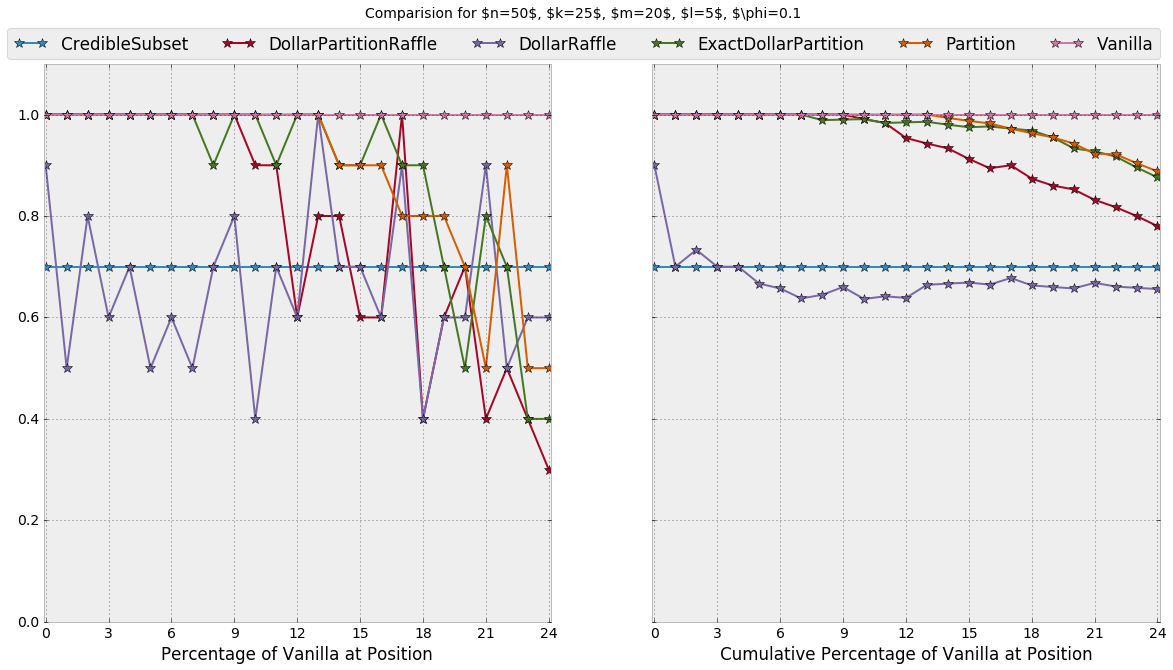

In [2]:
print(results.keys())
for i,key in enumerate(sorted(results.keys())):
    n, k, m, l, p, s = key
    df = pd.DataFrame(results[key])
    df_cum = pd.DataFrame(results[key])
    # Make between 0 and 1.0.
    for c in df.columns:
        df[c] = df[c] / float(s)
        df_cum[c] = df_cum[c].cumsum()
    for index, row in df_cum.iterrows():
        df_cum.loc[index,:] = row / float(s * (index+1))
    
    fig, axarr = plt.subplots(nrows=1, ncols=2, sharey=True)
    fig.set_size_inches(20, 10)
    df.plot(ax=axarr[0], ylim=(0, 1.1), marker="*", markersize=10, legend=False, xlim=(-0.1, float(k)-0.9))
    df_cum.plot(ax=axarr[1], ylim=(0, 1.1), marker="*", markersize=10, legend=False, xlim=(-0.1, float(k)-0.9))
    axarr[0].set_xlabel("Percentage of Vanilla at Position")
    axarr[1].set_xlabel("Cumulative Percentage of Vanilla at Position")
    xa = axarr[0].get_xaxis()
    xb = axarr[1].get_xaxis()
    xa.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True)) 
    xb.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True)) 
    plt.suptitle("Comparision for $n=" + str(n) +
        "$, $k=" + str(k) +
        "$, $m=" + str(m) +
        "$, $l=" + str(l) +
        "$, $\phi=" + str(p))
    plt.legend(bbox_to_anchor = (0,-0.05,1,1), bbox_transform=plt.gcf().transFigure, loc='upper center', ncol=6, borderaxespad=0.)


